<a href="https://colab.research.google.com/github/suinkangme/COMP432-GroupI/blob/main/COMP432_PROJECT_GROUP_I.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1. LOAD DATASET 1**

In [76]:
!gdown --fuzzy "https://drive.google.com/file/d/1M0uN1jbjbOh3b6fjDfe2qrNnYSJrgfwY/view?usp=drive_link"

Downloading...
From: https://drive.google.com/uc?id=1M0uN1jbjbOh3b6fjDfe2qrNnYSJrgfwY
To: /content/Dataset_1.zip
100% 831M/831M [00:08<00:00, 96.1MB/s]


In [ ]:
!unzip /content/Dataset_1.zip

Archive:  /content/Dataset_1.zip
replace Colorectal Cancer/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

**2. DATASET 1 PREPROCESSING**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

In [ ]:
# Define paths
base_dir = '/content/Colorectal Cancer'
classes = ['MUS', 'NORM', 'STR']

In [ ]:
# Initialize the ImageDataGenerator with rescaling
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=180,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.2,
    brightness_range=(0.9, 1.1),
    channel_shift_range=20,  # for slight color variations
    fill_mode='reflect'
)

In [ ]:
# Visually verify if the augmented images look correct
augmented_data_gen = datagen.flow_from_directory(
    base_dir,
    class_mode='categorical',
    batch_size=16,
    target_size=(224, 224),
    color_mode='rgb',
    shuffle=True
)

# Function to plot images
def plot_images(images_arr):
    fig, axes = plt.subplots(1, len(images_arr), figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Generate a batch of augmented images
augmented_images, _ = next(augmented_data_gen)

# Convert the images to unsigned integers for display
augmented_images = (augmented_images * 255).astype('uint8')

# Plot the images
plot_images(augmented_images[:5])  # Plotting 5 images, change as needed

In [64]:
from PIL import UnidentifiedImageError

# Function to load the images
def load_images_and_labels(class_dirs, target_size=(224, 224)):
  images = []
  labels = []
  for label, class_dir in enumerate(class_dirs):
    class_folder = os.path.join(base_dir, class_dir)
    for img_file in os.listdir(class_folder):
      img_path = os.path.join(class_folder, img_file)
      try:
          img = load_img(img_path, target_size=target_size)
          img = img_to_array(img)
          images.append(img)
          labels.append(label)
      except UnidentifiedImageError as e:
          print(f'Could not load image: {img_path}. Error: {e}')
    return np.array(images), np.array(labels)


# Load all the images and labels
images, labels = load_images_and_labels(classes)

# Apply data augmentation and normalization
augmented_images = datagen.flow(images, labels, batch_size=len(images), shuffle=True).next()

Could not load image: /content/Colorectal Cancer/MUS/.DS_Store. Error: cannot identify image file <_io.BytesIO object at 0x7badedcba610>


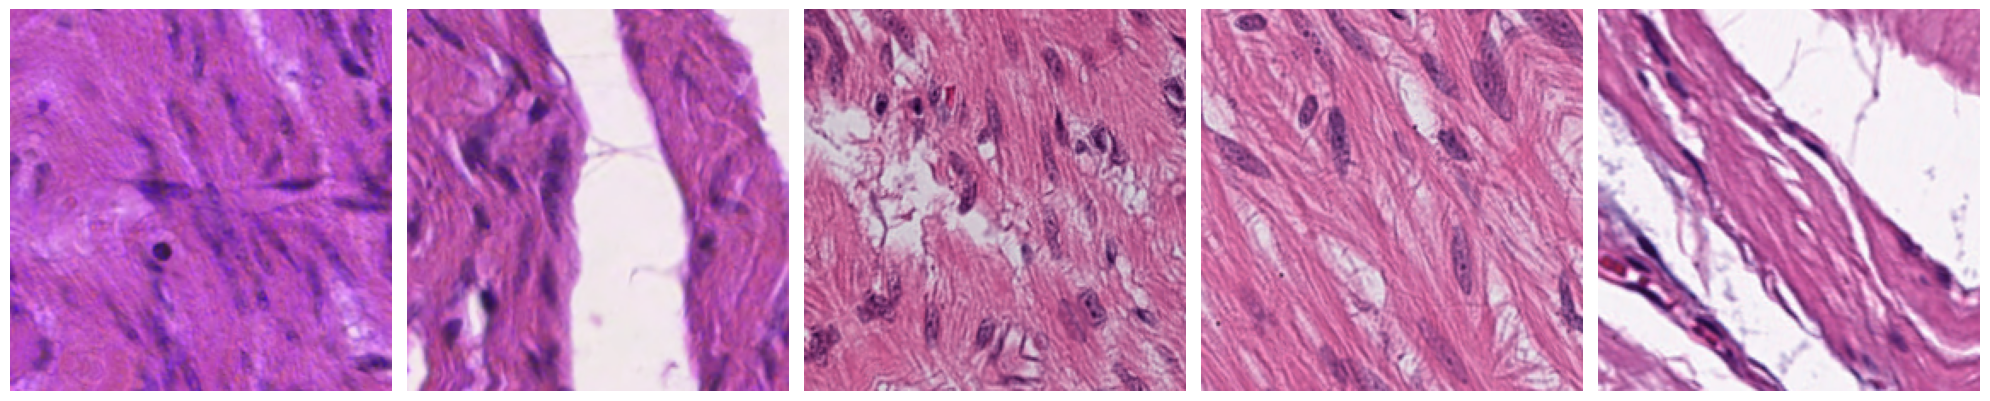

In [65]:
# Verify if the images are augmented correctly

# 'augmented_images' is a tuple where the first element is the image batch
# and the second element is the label batch. Need to separate them first.
augmented_images_batch, augmented_labels_batch = augmented_images

# Now 'augmented_images_batch' is the NumPy array you want to inspect.
# Select a random subset of images to display
num_images_to_display = 5
random_indices = np.random.choice(augmented_images_batch.shape[0], num_images_to_display, replace=False)
selected_images = augmented_images_batch[random_indices]

# Convert the selected images to unsigned integers for display if they have been rescaled
selected_images_uint8 = (selected_images * 255).astype('uint8')

# Use the plot_images function to display the selected images
plot_images(selected_images_uint8)


In [66]:
# Split the data and save the sets into npy arrays

# Perform a train-test split
X_train, X_test, y_train, y_test = train_test_split(
    augmented_images_batch, augmented_labels_batch,
    test_size=0.2,
    random_state=42
)

In [67]:
# Save the splits to .npy files
np.save('/content/train_images.npy', X_train)
np.save('/content/train_labels.npy', y_train)
np.save('/content/test_images.npy', X_test)
np.save('/content/test_labels.npy', y_test)

In [68]:
from google.colab import files

files.download('train_images.npy')
files.download('train_labels.npy')
files.download('test_images.npy')
files.download('test_labels.npy')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**3. TRAIN RESNET18 FOR DATASET 1**

In [69]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
from torchvision.models import resnet18
from torch.utils.data import DataLoader, TensorDataset

In [70]:
# Load the training and testing data
X_train = np.load('/content/train_images.npy')
y_train = np.load('/content/train_labels.npy')
X_test = np.load('/content/test_images.npy')
y_test = np.load('/content/test_labels.npy')

In [71]:
# Convert the data to PyTorch tensors
X_train_tensor = torch.from_numpy(X_train)
y_train_tensor = torch.from_numpy(y_train)
X_test_tensor = torch.from_numpy(X_test)
y_test_tensor = torch.from_numpy(y_test)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

In [72]:
# DataLoader for training and test data
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [73]:
# Define ResNet-18 model with pre-trained weights
model = resnet18(pretrained=True)
num_classes = len(classes)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, num_classes)

In [74]:
# Set loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [75]:
# Training the model
num_epochs = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Print training loss and accuracy for each epoch
    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%')


RuntimeError: ignored

### Note during the training

Hyperparameter

1) batch size

2) optimizer

3) number of epoch